In [2]:
%matplotlib inline
import pysal as ps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point
import seaborn as sns
from matplotlib import cbook
import spvcm.api as spvcm 
import sys
from spvcm import plotting
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# path = '/media/sam/sam_hdd/manchester_case_study/'
path = 'c:/Users/sgscombe/Documents/manchester_case_study/'

This notebook presents ESDA and inferential analysis that attempts to recover an 'attractiveness' effect between town centre boundaries across Greater Manchester.

In [3]:
# read manchester shapefile and ldc stores 
manc = gpd.read_file(path+'manchester_catchments.shp')

ldc_data = pd.read_csv(path + '/data/modelling_hsar.csv')
ldc_data = ldc_data[ldc_data['PremiseStatus'] == 'Live'] 

# convert to geopandas
geometry = [Point(xy) for xy in zip(ldc_data['Geocode Easting'].astype(float), ldc_data['Geocode Northing'].astype(float))]
ldc_data_gpd = gpd.GeoDataFrame(ldc_data, crs=manc.crs, geometry=geometry)
ldc_data = sjoin(ldc_data_gpd.drop('index_right', axis=1), manc[['geometry']], op='within')

In [4]:
# keep only intersecting catchments
catchments = gpd.read_file(path+'shps/m_weights.shp')
catchments = catchments[catchments.cluster_id.isin(ldc_data.cluster_id.tolist())] 
catchments = catchments.drop_duplicates(subset='cluster_id')
catchments = catchments.set_index('cluster_id').sort_index()

In [5]:
# build lower-level design matrix
dummies_store_category = pd.get_dummies(ldc_data.cat_Name1).columns # store categories
ldc_data = ldc_data.merge(pd.get_dummies(ldc_data.cat_Name1), left_index=True, right_index=True)
ldc_data = ldc_data.sort_values('cluster_id') 
features_store_category = dummies_store_category.tolist()
features_store_category.remove('Showrooms') # drop reference dummies
features = list(cbook.flatten(['no_rooms', 'total_area', 'car_park_spaces', 
                               features_store_category]))

In [6]:
# use gravity weights to define neighbours
m = ps.weights.DistanceBand.from_dataframe(catchments,
                                           threshold=5000,  # inferred from variogram
                                           binary=False,
                                           alpha = -2.0);
m.dmat

<130x130 sparse matrix of type '<class 'numpy.float64'>'
	with 2022 stored elements in Compressed Sparse Row format>

In [7]:
# lower-level design matrix
X = ldc_data[features].values 
# observations
N = X.shape[0]
# higher-level design matrix
Z = np.eye(catchments.shape[0])
# regions
J = Z.shape[0]
# response
Y = ldc_data.total_value.values.reshape(-1, 1)
Y = np.log(Y)

# N x J
membership = ldc_data.cluster_id.apply(lambda x: m.id_order.index(x)).values

print(X.shape, sep='\n')
print(Z.shape, sep='\n')

(14982, 16)
(130, 130)


Here we build the samplers from SPVCM.

In [9]:
sese = spvcm.upper.SE(Y, X,M=m, membership=membership, 
                         n_samples=11000, n_jobs=1, 
                         configs=dict(tuning=500, adapt_step=1.01));

upper_sma = spvcm.upper.SMA(Y,X,M=m, membership=membership,  
                         n_samples=11000, n_jobs=1, 
                         configs=dict(tuning=500, adapt_step=1.01), verbose=True);

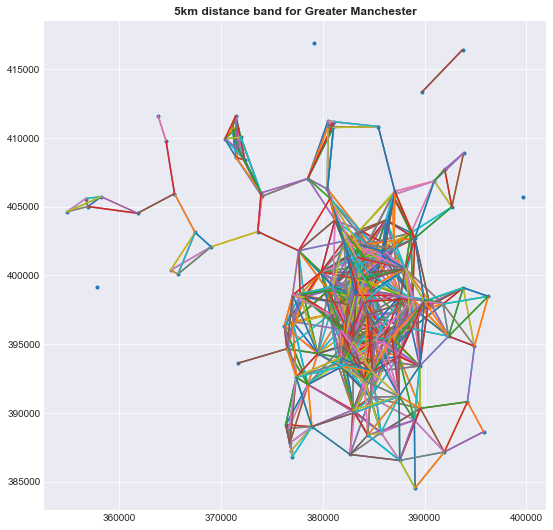

In [156]:
centroids = np.array([np.array(poly.centroid) for poly in catchments.geometry])

f, ax = plt.subplots(1, figsize=(9,9))

plt.plot(centroids[:,0], centroids[:,1],'.')

for k, neighs in m.neighbors.items():
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k, neigh]]
        plt.plot(segment[:, 0], segment[:,1], '-')

plt.title('5km distance band for Greater Manchester', fontdict={'fontweight': 'bold'})
plt.show()

In [9]:
# retrieve point estimates of alphas and se
sese_var_int = spvcm.diagnostics.point_estimates(sese, burnin=1000)[0]['Alphas']
sese_error = spvcm.diagnostics.mcse(sese)['Alphas']
sma_var_int = spvcm.diagnostics.point_estimates(upper_sma, burnin=1000)[0]['Alphas']
sma_error = spvcm.diagnostics.mcse(upper_sma)['Alphas']

se_intercept = spvcm.diagnostics.point_estimates(sese, burnin=1000)[0]['Betas'][0]
sma_intercept = spvcm.diagnostics.point_estimates(upper_sma, burnin=1000)[0]['Betas'][0]

sese_var_int = list(map(lambda x : x + se_intercept, sese_var_int))
sma_var_int = list(map(lambda x : x + sma_intercept, sma_var_int))

In [10]:
len(sese_var_int) == len(sese_error) == len(sma_var_int) == len(sma_error)

True

In [106]:
upper_sma = spvcm.Trace.from_csv(path+'models/upper_sma.csv')
sese = spvcm.Trace.from_csv(path+'models/sese.csv')

In [34]:
# build df output from SPVCM samplers
pd.DataFrame({
    'cluster_id':ldc_data.cluster_id.unique().tolist(),
    'sma_var_int':sma_var_int,
    'sma_error':sma_error,
    'sese_var_int':sese_var_int,
    'sese_error':sese_error
}).set_index('cluster_id').to_csv(path+'results/spatial_out.csv')

In [10]:
# spatial fixed effects output
fe = pd.read_csv(path+'results/spatial_fe.csv')
fe['cluster_id'] = fe['Unnamed: 0'].str[10:] # clean cluster ids
fe = fe.drop(['Unnamed: 0'], axis=1); fe.columns = ['fe_est', 'fe_se', 'cluster_id']

hsar = pd.read_csv(path+'/results/hsar_out.csv').drop('Unnamed: 0', axis=1)
# hsar = pd.read_csv(path+'/results/hsar_unmodded_out.csv').drop('Unnamed: 0', axis=1)
spatial = pd.read_csv(path+'results/spatial_out.csv')
mlm = pd.read_csv(path+'results/mlm_out.csv').drop('Unnamed: 0', axis=1)
mlm_sim = pd.read_csv(path+'results/a_rep.csv').drop('Unnamed: 0', axis=1).transpose()
hse = pd.read_csv(path+'results/hse_out.csv').drop('Unnamed: 0', axis=1)

def get_code(x):
    return x.split('.')[0]

mlm_sim['cluster_id'] = list(map(get_code, mlm_sim.index.tolist()))

In [11]:
from functools import reduce

dfs = [mlm, hsar, hse, fe, spatial, mlm_sim]

#coalesce to one frame
master = reduce(lambda left,right: pd.merge(left,right,on='cluster_id'), dfs) 

# sort by mlm estimator which we take as baseline
master = master.sort_values(['mlm_est'], ascending=False).reset_index(drop=True)

master.head()

cluster_id    mlm_est    mlm_se  theta_est  theta_sd    hse_est    hse_sd  \
0     RC0033  11.529009  0.040857  11.531117  0.087724  11.528769  0.078031   
1     RC0146  11.367100  0.269140  11.370298  0.280067  11.379506  0.280173   
2     RC0083  11.035576  0.086159  11.037812  0.116072  11.035315  0.107676   
3     RC0080  11.011980  0.288040  11.021430  0.298935  11.026048  0.295686   
4     RC0037  10.993520  0.068429  10.995623  0.104820  10.992284  0.096174   

      fe_est     fe_se  sese_error    ...            990        991  \
0  11.534927  0.058489    0.005817    ...      11.416270  11.532387   
1  11.655855  0.288429    0.005594    ...      10.875804  11.262845   
2  11.063116  0.095923    0.005750    ...      11.005745  11.129583   
3  11.295732  0.311423    0.005483    ...      10.991689  10.950570   
4  11.013976  0.079990    0.005723    ...      10.964236  11.009672   

         992        993        994        995        996        997  \
0  11.564077  11.544404  11.457040  11.539995  11.689107  11.535615   
1  11.257660  11.703247  11.478254  11.505461  10.912036  11.433333   
2  11.049037  11.136532  11.038946  11.094987  10.983341  11.017050   
3  10.109823  10.585259  11.051166  10.645242  11.154664  10.937512   
4  10.949082  11.020616  10.905729  10.874441  11.038477  11.147671   

         998        999  
0  11.505037  11.430020  
1  11.366328  11.373203  
2  11.041266  10.821456  
3  11.038256  11.522033  
4  11.018080  11.009182  

[5 rows x 1013 columns]

In [12]:
import itertools

fontsizes_x = itertools.cycle([32, 40, 48, 56]) 
fontsizes_y = itertools.cycle([32, 40, 48, 56])

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.pyplot import cm 

def plot_ranef(use_sim=False):

    sns.set_style("darkgrid")
    sns.set_context(rc = {'patch.linewidth': 2})

    f, ax = plt.subplots(1, figsize=(60,30))
    
    if use_sim == True:
        
        color=cm.rainbow(np.linspace(0,1,n))

        for a_sim, c in zip(master.iloc[:, 11:].iterrows(), color):
            ax.plot(master.iloc[:, 11:].iloc[:,a_sim[0]], color=c)
        
        #### classical multilevel model
        ax.plot(master.mlm_est, color='#000000', linewidth=5)    
    
        ax.set_xlabel('Rank Order', fontsize=next(fontsizes_x))
        ax.set_ylabel(r'Attractiveness Effect ($\theta_j$)', fontsize=next(fontsizes_y))
        
        fs = 14
        for xtick, ytick in zip(ax.yaxis.get_major_ticks(), ax.xaxis.get_major_ticks()):
            xtick.label.set_fontsize(fs) 
            ytick.label.set_fontsize(fs)   

        ax.xaxis.labelpad = 20
        ax.yaxis.labelpad = 20
        plt.xticks(fontsize=48)
        plt.yticks(fontsize=48)
        plt.savefig(path+'results/mlm_sim.png')


        return

    #### FE model
    ax.plot(master.fe_est, color='#24A346')
    ax.fill_between(master.index, master.fe_est+master.fe_se, master.fe_est-master.fe_se, 
                    alpha=.1, 
                    color='#24A346')

    #### SE
    ax.plot(master.sese_var_int, color='#0000FF')
    ax.fill_between(master.index, master.sese_var_int+master.sese_error, master.sese_var_int-master.sese_error, 
                    alpha=.1, 
                    color='#0000FF')

    #### classical multilevel model
    ax.plot(master.mlm_est, color='#FFA233')
    ax.fill_between(master.index, master.mlm_est+master.mlm_se, master.mlm_est-master.mlm_se, 
                    alpha=.1, 
                    color='#FFA233')

    #### sma model
    ax.plot(master.sma_var_int, color='#de2d26')
    ax.fill_between(master.index, master.sma_var_int+master.sma_error, master.sma_var_int-master.sma_error, 
                    alpha=.1, 
                    color='#de2d26')

    #### hsar model
    ax.plot(master.theta_est, color='#f442d7')
    ax.fill_between(master.index, master.theta_est+master.theta_sd, master.theta_est-master.theta_sd, 
                    alpha=.1, 
                    color='#f442d7')
    

    #### hse model
#     ax.plot(master.hse_est, color='#000000')
#     ax.fill_between(master.index, master.hse_est+master.hse_sd, master.hse_est-master.hse_sd, 
#                     alpha=.1, 
#                     color='#000000')


    ax.set_xlabel('Rank Order', fontsize=next(fontsizes_x))
    ax.set_ylabel(r'Attractiveness Effect ($\theta_j$)', fontsize=next(fontsizes_y))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['FE','SE', 'MLM', 'SMA', 'HSAR'], fontsize = 48)
    fs = 14
    for xtick, ytick in zip(ax.yaxis.get_major_ticks(), ax.xaxis.get_major_ticks()):
        xtick.label.set_fontsize(fs) 
        ytick.label.set_fontsize(fs)   

    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 20
    plt.xticks(fontsize=48)
    plt.yticks(fontsize=48)


    with plt.style.context("seaborn-darkgrid"):

        plt.rcParams["axes.edgecolor"] = "0.15"
        plt.rcParams["axes.linewidth"]  = 2
        axins = zoomed_inset_axes(ax, 3,  loc=3)
        axins.plot(master.theta_est)

        #### FE model
        axins.plot(master.fe_est, color='#24A346')
        axins.fill_between(master.index, master.fe_est+master.fe_se, master.fe_est-master.fe_se, 
                        alpha=.1, 
                        color='#24A346')

        #### SE
        axins.plot(master.sese_var_int, color='#0000FF')
        axins.fill_between(master.index, master.sese_var_int+master.sese_error, master.sese_var_int-master.sese_error, 
                        alpha=.1, 
                        color='#0000FF')

        #### classical multilevel model
        axins.plot(master.mlm_est, color='#FFA233')
        axins.fill_between(master.index, master.mlm_est+master.mlm_se, master.mlm_est-master.mlm_se, 
                        alpha=.1, 
                        color='#FFA233')

        #### sma model
        axins.plot(master.sma_var_int, color='#de2d26')
        axins.fill_between(master.index, master.sma_var_int+master.sma_error, master.sma_var_int-master.sma_error, 
                        alpha=.1, 
                        color='#de2d26')

        #### hsar model
        axins.plot(master.theta_est, color='#f442d7')
        axins.fill_between(master.index, master.theta_est+master.theta_sd, master.theta_est-master.theta_sd, 
                        alpha=.1, 
                        color='#f442d7')

        axins.spines['top'].set_color('0.1')
        axins.spines['bottom'].set_color('0.1')
        axins.spines['right'].set_color('0.1')
        axins.spines['left'].set_color('0.1')

        plt.setp(axins.patches, linewidth=5)

        axins.set_xlim(2, 12)
        axins.set_ylim(10.5, 11.1)

        plt.xticks(visible=False)
        plt.yticks(visible=False)

        mark_inset(ax, axins, loc1=2, loc2=1, fc='0', ec='0')

    plt.savefig(path+'results/compare_methods.png')
    plt.draw()
    plt.show()

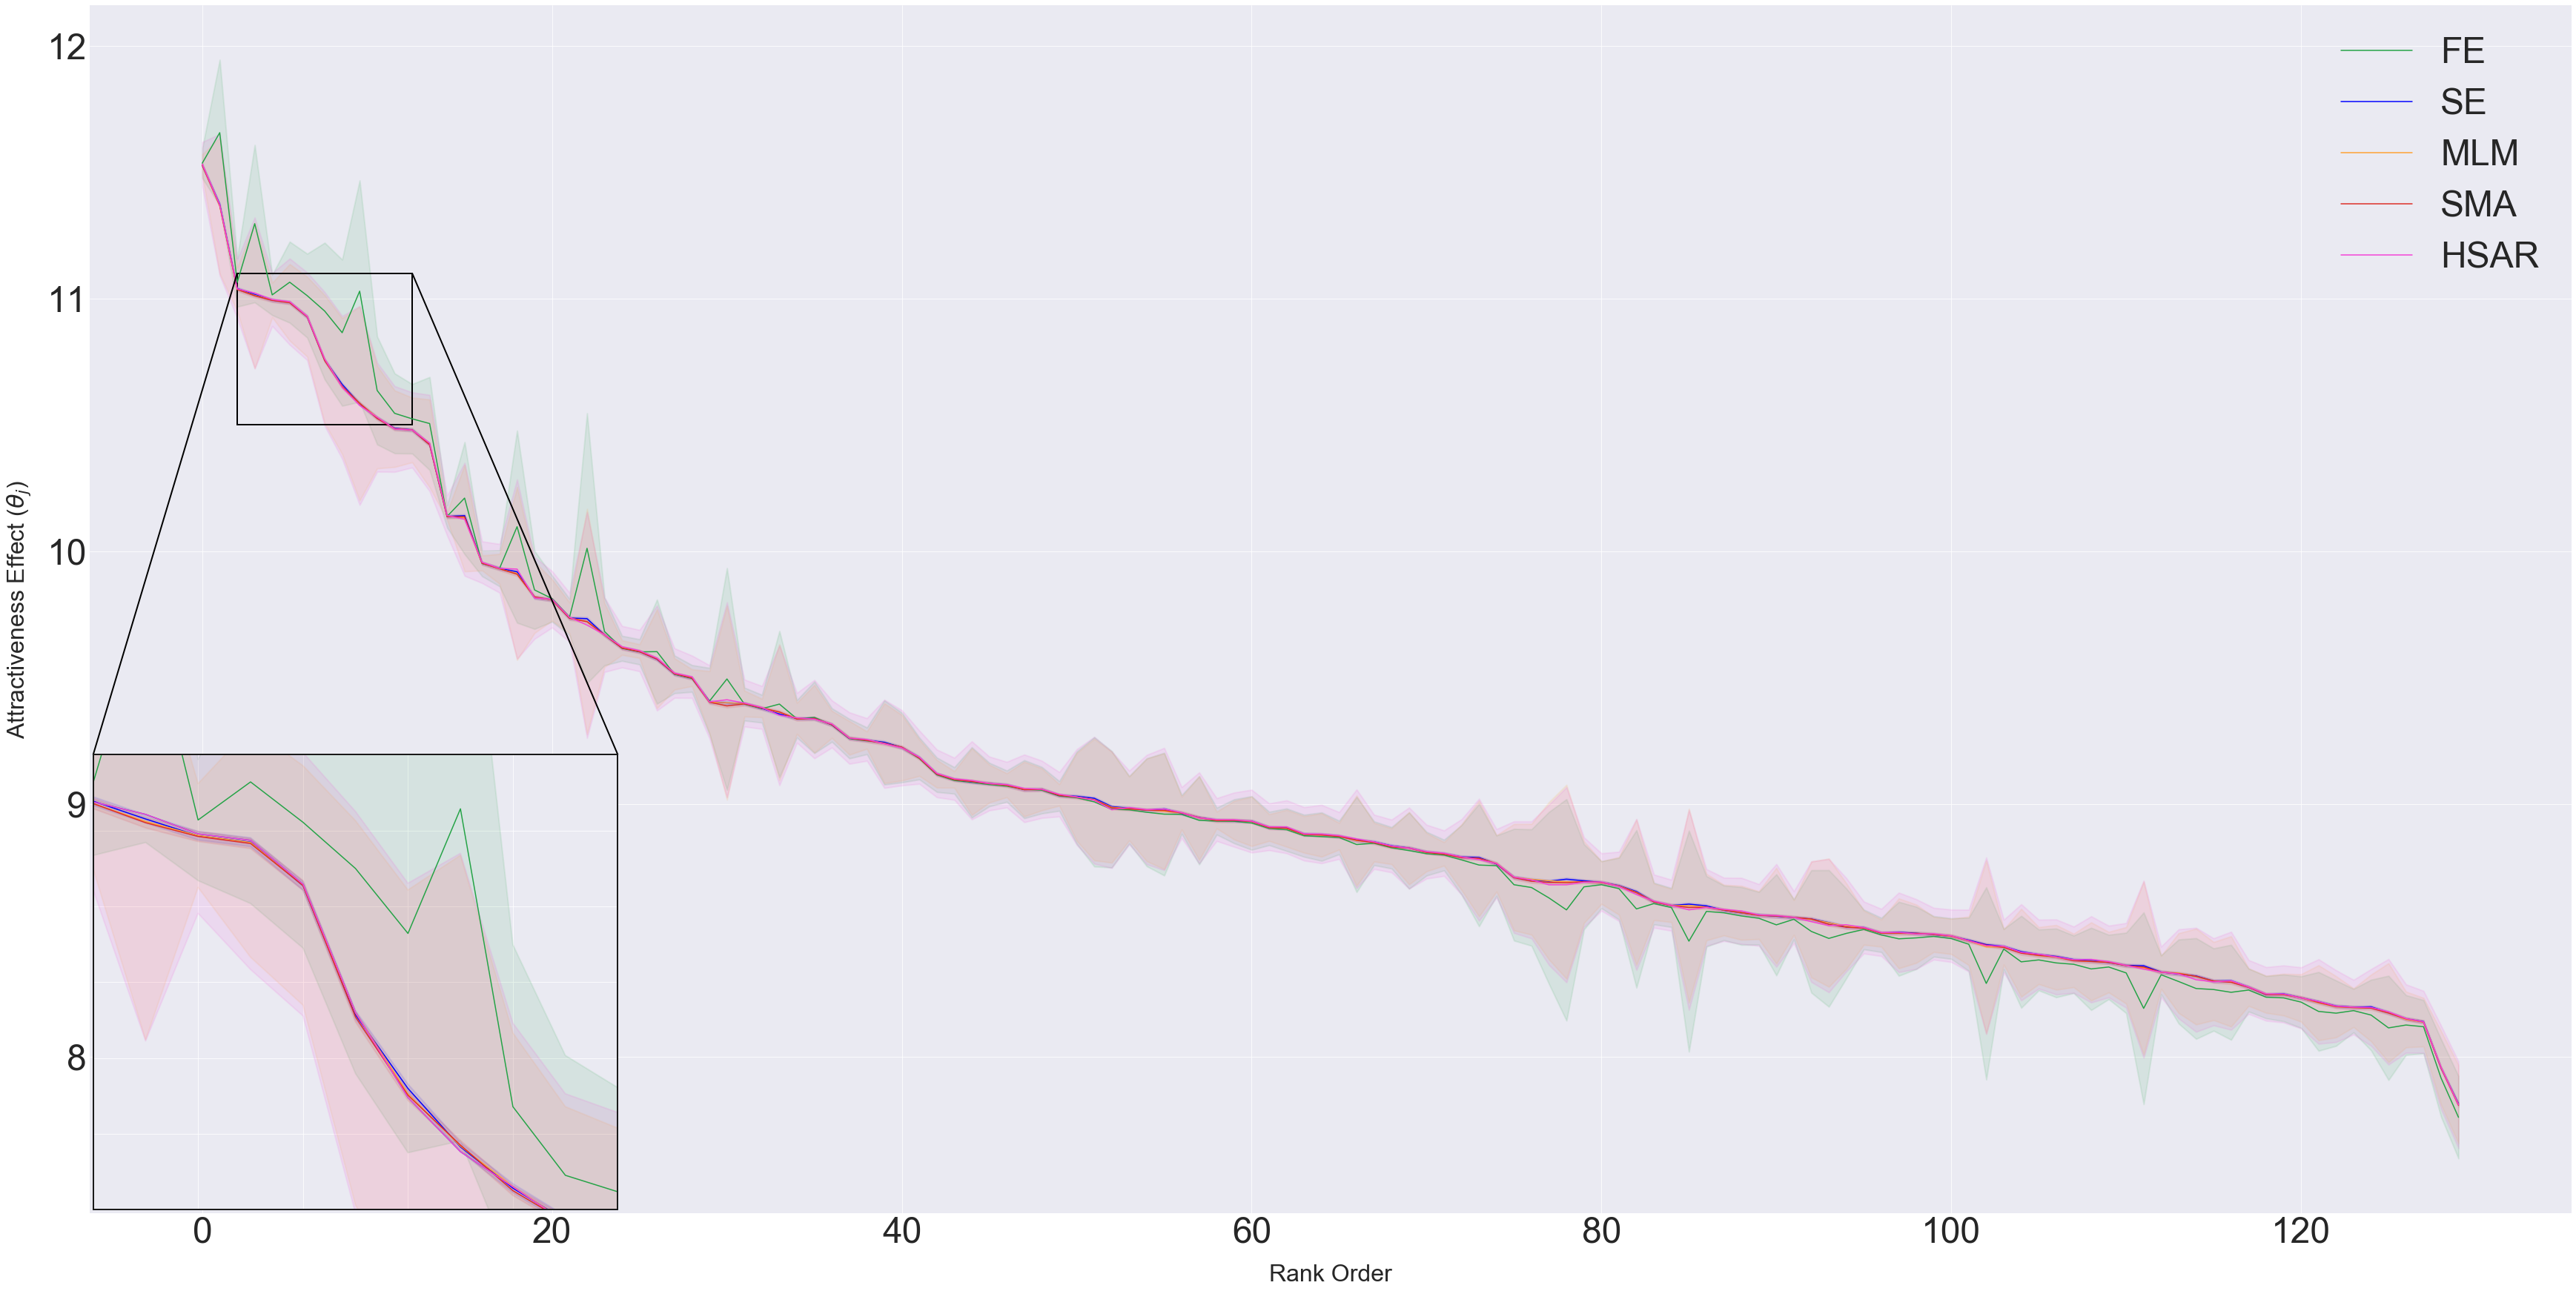

In [14]:
plot_ranef()

One aspect of the figure is striking: the systematic overlap and/or consistency of $\theta_j$ across all of the multilevel models. This raises a few questions: why are each of the estimates practically symmetrical? 

Let's build some intuition as to why we might assume the multilevel models to be different. Take for example a test case for upper-level $M$:

$$M = \begin{pmatrix}
0 & 1 & 0 \\
1 & 0 & 1 \\ 
0 & 1 & 0
\end{pmatrix}$$

If we assume global interaction by assigning $\lambda= 0.6$ across the entire spatial system, our resulting spatial filter looks like:


$$(I_3 - 0.6M)^{-1} = 
\begin{pmatrix}
2.2857 & 2.1428 & 1.2857\\
2.1428 & 3.5714 & 2.1428\\
1.2857 & 2.1428 & 2.2857
\end{pmatrix}
$$

Where the first boundary ($w_{i1}$) derives utility reflecting a linear combination of characteristics of its own area, as well as characteristics of both other town centres in the region, with the weight placed on own-boundary ($w_{11}=2.2857$ ) characteristics just under 2 times that of the third boundary ($w_{31} = 1.2857$) which reflects a second-order neighbour. Increasing the value of $\lambda$ will increase the magnitude of the weights, as well as decrease the distance decay moving between neighbours. Implicit in this formulation is that shocks are channeled across the entire system.

In an SMA, the data generating process is specified as:

$$
\epsilon = \gamma Mu + u
$$

In particular, removing the inverse results in local range for the induced variance. Following our example, our spatial filter now looks like:

$$(I_3 - 0.6M) = 
\begin{pmatrix}
1, -0.6,  0 ,\\
-0.6,  1 , -0.6,\\
 0 , -0.6,  1
\end{pmatrix}
$$

where beyond two bands of neighbours (i.e. first- and second order neighbours), the spatial covariance is zero. If this interpretation is correct $W_{31}$ is a second-order neighbour of $W_{11}$ (being linked by the second row), and so the spatial covariance <b><i>should</i></b> be non-zero. This is my first point of confusion with the SMA, is my interpretation correct? 

Even so, if shrinkage for the SMA estimator is pulled not only towards the global mean, but also the neighbourhood mean of town centre boundary attractiveness, then I would expect the estimates to appear more dispersed around the estimates that are recovered for the other models. In particular, I would expect this because the LISA plot (see below) confirms a number of cases of different boundaries with high values close to low values (and similar for LH, HH, LL). 

Although not many of the local Morans values were significant, this might still imply a discontinuity in the spatial structure, in which case the local neighbourhoods should have different means. In this case, one might expect a lot more scatter in the SMA estimates (relative to the other models) observed in the figure above. This is unless, of course, the weighting of the complete pooling model is higher than the neighbourhood shrinkage.

In [39]:
M = np.matrix([[0,1,0],
               [1,0,1],
               [0,1,0]])
I = np.eye(3)
lamd = [.6, -0.02, -0.04]

for lam in lamd:

    spatial_filter = I - np.dot(lam,M)

    S = np.linalg.inv(spatial_filter)

    print('Lambda: {}'.format(lam))
    print(S)

Lambda: 0.6
[[ 2.28571429  2.14285714  1.28571429]
 [ 2.14285714  3.57142857  2.14285714]
 [ 1.28571429  2.14285714  2.28571429]]
Lambda: -0.02
[[  1.00040032e+00  -2.00160128e-02   4.00320256e-04]
 [ -2.00160128e-02   1.00080064e+00  -2.00160128e-02]
 [  4.00320256e-04  -2.00160128e-02   1.00040032e+00]]
Lambda: -0.04
[[ 1.00160514 -0.04012841  0.00160514]
 [-0.04012841  1.00321027 -0.04012841]
 [ 0.00160514 -0.04012841  1.00160514]]


In addition, let's plot simulated draws of $\theta_j$ for the classical MLM.

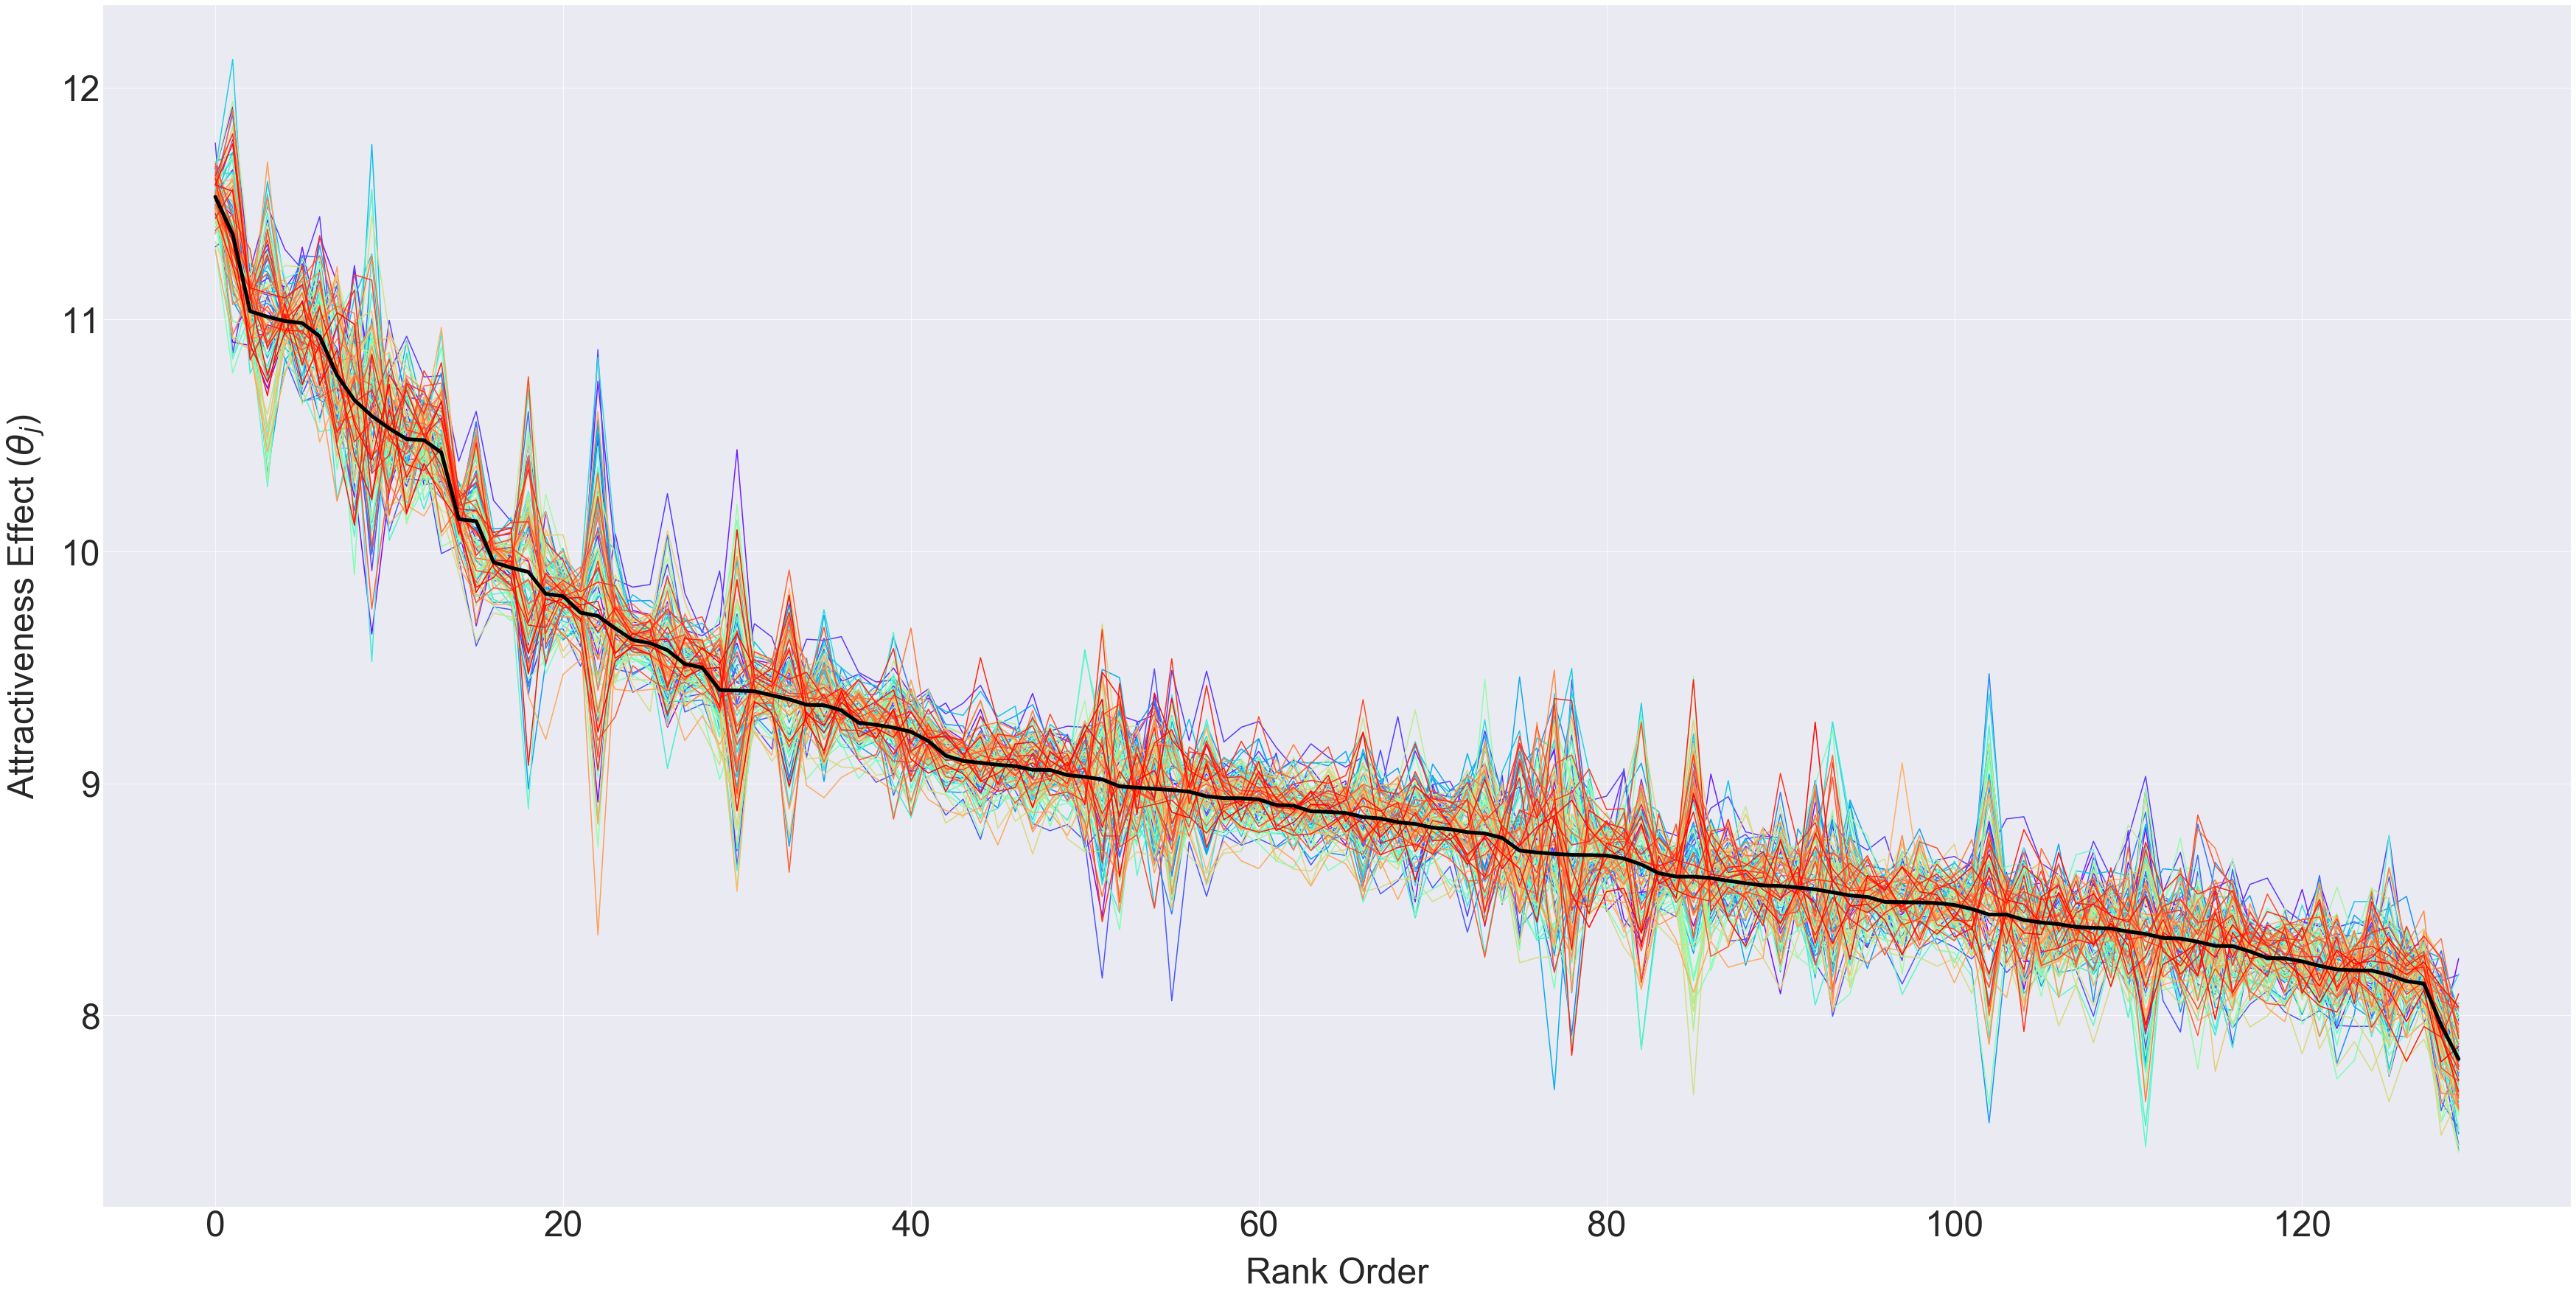

In [146]:
plot_ranef(use_sim=True)

Now we undertake model checking.

In [81]:
def fitted_vals(x, betas, kv_dict):
                
    alpha = kv_dict[x['cluster_id']]

    intercept = betas[0]

    betas_list = betas[1:]

    xB = [b*x[var] for var, b in zip(x_vars, betas_list)]

    return intercept + np.sum(xB) + alpha    

def rmse(error):
    return np.sqrt(((error) ** 2).mean())

def AIC(error, n_betas):
    
    n = len(ldc_data)
    RSS = np.sum(error**2)
    log_likelihood = -n/2*(np.log(2*np.pi) + np.log(RSS/n) + 1) 
    
    AIC = -2*log_likelihood + 2 * (n_betas +1)
    
    return AIC

We build a dictionary with key/value pairs reflecting coefficient name and value.

In [82]:
# build dictionary of coefficients to variables to construct fitted vals
x_vars = ldc_data[features].columns.tolist()

### se
betas_se = spvcm.diagnostics.point_estimates(sese)[0]['Betas']
keys = ldc_data.cluster_id.unique().tolist()
values = spvcm.diagnostics.point_estimates(sese)[0]['Alphas']
se_kv = dict(zip(keys, values))

### sma
betas_sma = spvcm.diagnostics.point_estimates(upper_sma)[0]['Betas']
keys = ldc_data.cluster_id.unique().tolist()
values = spvcm.diagnostics.point_estimates(upper_sma)[0]['Alphas']
sma_kv = dict(zip(keys, values))

### hsar
hsar_coef = pd.read_csv(path+'/models/hsar_coefs.csv')
betas_hsar = hsar_coef.iloc[:,1].tolist()
alphas_hsar = pd.read_csv(path+'/models/hsar_alphas.csv')
keys = alphas_hsar.cluster_id
values = alphas_hsar.theta_est
hsar_kv = dict(zip(keys, values))

In [12]:
# retrieve fitted values for each model
spatial_fe_fitted = pd.read_csv (path+'results/fitteds/spatial_fe_fitted.csv', header=0, names=['id','fitted_fe'], index_col='id')
mlm_fitted = pd.read_csv (path+'results/fitteds/mlm_fitted.csv', header=0, names=['id','fitted_mlm'], index_col='id')

ldc_data['log_val'] = np.log(ldc_data['total_value']) 

ldc_data['fitted_hsar'] = ldc_data.apply(fitted_vals, args=(betas_hsar, hsar_kv), axis=1)
ldc_data['fitted_sma']  = ldc_data.apply(fitted_vals, args=(betas_sma, sma_kv), axis=1)
ldc_data['fitted_se']   = ldc_data.apply(fitted_vals, args=(betas_se, se_kv), axis=1)
ldc_data['fitted_fe'],  ldc_data['fitted_mlm'] = spatial_fe_fitted.values, mlm_fitted.values 

# check them out quickly
ldc_data[['log_val','fitted_fe', 'fitted_mlm', 'fitted_hsar', 'fitted_sma', 'fitted_se']].head()

Next we plot actual observations by their predicted value to visually inspect model fit.

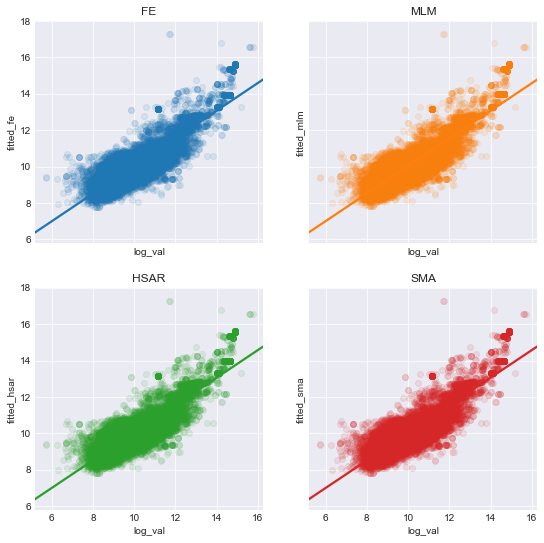

In [531]:
f, ax = plt.subplots(2,2, figsize=(9,9), sharey=True, sharex=True)

ax[0,0].set_title('FE')
sns.regplot(ldc_data['log_val'], ldc_data['fitted_fe'], ax=ax[0,0], scatter_kws={'alpha':0.1})

ax[0,1].set_title('MLM')
sns.regplot(ldc_data['log_val'], ldc_data['fitted_mlm'], ax=ax[0,1], scatter_kws={'alpha':0.1})

ax[1,0].set_title('HSAR')
sns.regplot(ldc_data['log_val'], ldc_data['fitted_hsar'], ax=ax[1,0], scatter_kws={'alpha':0.1})

ax[1,1].set_title('SMA')
sns.regplot(ldc_data['log_val'], ldc_data['fitted_sma'], ax=ax[1,1], scatter_kws={'alpha':0.1})

plt.show()

Let's create hex bins to see whether we can visually differentiate between the fit tightness.

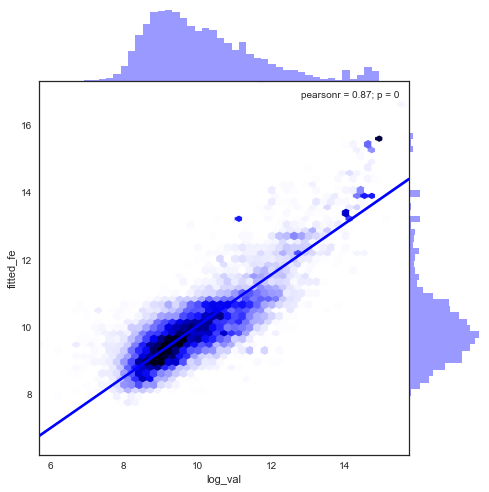

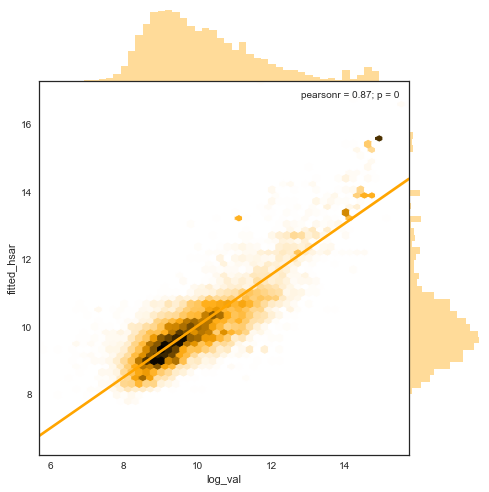

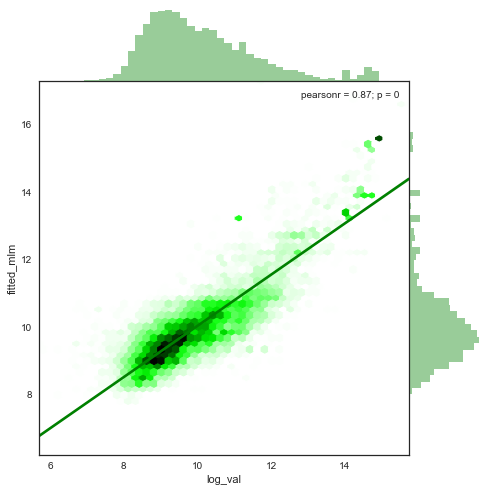

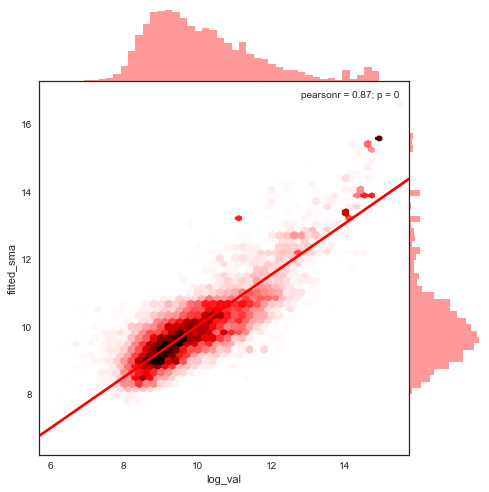

In [568]:
fe = sns.jointplot(ldc_data['log_val'], ldc_data['fitted_fe'], kind='hex', size=7, space=0, color='blue')
sns.regplot(ldc_data['log_val'], ldc_data['fitted_fe'], ax=fe.ax_joint, scatter=False, color='blue');

hsar = sns.jointplot(ldc_data['log_val'], ldc_data['fitted_hsar'], kind='hex', size=7, space=0, color='orange')
sns.regplot(ldc_data['log_val'], ldc_data['fitted_hsar'], ax=hsar.ax_joint, scatter=False, color='orange');

mlm = sns.jointplot(ldc_data['log_val'], ldc_data['fitted_mlm'], kind='hex', size=7, space=0, color='green')
sns.regplot(ldc_data['log_val'], ldc_data['fitted_mlm'], ax=mlm.ax_joint, scatter=False, color='green');

sma = sns.jointplot(ldc_data['log_val'], ldc_data['fitted_sma'], kind='hex', size=7, space=0, color='red')
sns.regplot(ldc_data['log_val'], ldc_data['fitted_sma'], ax=sma.ax_joint, scatter=False, color='red');

Now let's create more objective, numerical measures of fit where available. 

In [668]:
error_fe = ldc_data['log_val'] - ldc_data['fitted_fe']
error_mlm = ldc_data['log_val'] - ldc_data['fitted_mlm']
error_hsar = ldc_data['log_val'] - ldc_data['fitted_hsar']
error_sma = ldc_data['log_val'] - ldc_data['fitted_sma']
error_se = ldc_data['log_val'] - ldc_data['fitted_se']

# r2/loglik/aic values taken from R output (rpy2 doesn't work on my machine)
model_checking = pd.DataFrame({
    'rss': [error_fe.sum(), error_mlm.sum(), error_hsar.sum(), error_sma.sum(), error_se.sum()],
    'rmse':[rmse(error_fe), rmse(error_mlm), rmse(error_hsar), rmse(error_sma), rmse(error_se)],
    'log_likelihood':[-16982.31, -17361.84, -18364.29,'-','-'],
    'r2 (pseudo)': [0.9946 , 0.7216, 0.7554,'-','-'],
    'AIC': [34258.62, 34761.68, 36764.57, '-','-']
}, index=['fe', 'mlm', 'hsar', 'sma', 'se'])

Although the $R^2$ is unreliable given we set the origin of intercept as 0, it appears the spatial FE model provides the best fit under AIC, the log likelihood and RMSE. Perhaps the RMSE doen't penalize for the number of coefficients? AIC penalizes models for adding extra terms. The term $2k$ means the AIC increases by up to 2 for every additional parameter estimated.

$$
AIC = 2k - 2\text{ log}(\hat L)
$$

If you look at the RSS, it would appear that adding the 130 fixed effects (for each town centre boundary) is actually giving us a lot of benefit relative to models that are 'borrowing strength' from others.

In [750]:
model_checking.reindex_axis(sorted(model_checking.columns, reverse=True), axis=1)

rss      rmse r2 (pseudo) log_likelihood      AIC
fe    3.954170e-12  0.751695      0.9946       -16982.3  34258.6
mlm   9.956693e-10  0.751894      0.7216       -17361.8  34761.7
hsar  5.035315e-01  0.751888      0.7554       -18364.3  36764.6
sma   1.697700e+00  0.751896           -              -        -
se    2.810661e+00  0.751895           -              -        -

Let's try to summarize the amount of pooling so we can get a grasp on how/why the spatial FE model fits the data better than the multilevel models. We use the formula in Gelman and Hill:

$$
\text{pooling factor } \lambda_j = \frac{(\text{standard error of }\epsilon_j)^2}{\sigma_{alpha}^2}
$$

where town centre boundaries with small sample sizes should have pooling factors nearer to 1 (complete pooling), and larger town centre boundaries should have pooling factors closer to 0 (no pooling estimates). We calculate a vector of $J$ pooling factors below.

In [927]:
ldc_data['residuals_se'] = ldc_data['log_val'] - ldc_data['fitted_se']

# se of e_j
raw_resid_j = ldc_data.groupby('cluster_id')['residuals_se'].std().to_frame()

# sigma.a
sigma_a = spvcm.diagnostics.point_estimates(sese)[0]['Tau2']
sigma_e = spvcm.diagnostics.point_estimates(sese)[0]['Sigma2']

######### load valus with pmin applied as in gelman and hill so range <= 1
pmin_pool = pd.read_csv(path+'data/pooling_factors_r.csv')
pooling_factors = pmin_pool.iloc[:,1]

raw_resid_j['pooling_factor'] = pooling_factors.values

# plot pooling factor by sample size
pooling_factors = raw_resid_j.join(store_per_catch)

pooling_factors.columns = ['residuals', 'pooling_factor', 'sample_size']

Let's compare Gelman's pooling factor to the raw shrinkage multiplier used per town center boundary for the residuals of the upper-level spatial error model.

$$
\text{shrinkage factor}= \frac{\sigma_u^2}{\sigma_u^2 + \sigma_e^2 / n_j}.
$$

In [968]:
%%capture
pooling_factors['shrinkage_factor'] = sigma_a / (sigma_a + sigma_e / pooling_factors['sample_size']) 

f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(9,3))

sns.regplot( pooling_factors['pooling_factor'], 
           pooling_factors['sample_size'], ax=ax1,scatter_kws={'color':'r', 'alpha':0.6}, color='black')

sns.regplot(pooling_factors['shrinkage_factor'], 
           pooling_factors['sample_size'], ax=ax2, scatter_kws={'color':'g', 'alpha':0.6}, color='black')

plt.show()

In general, the shrinkage factor will be smaller (more shrinkage) the larger the level 1 residual variance ($\sigma_e^2$) compared with the intercept variance ($\sigma_u^2$), and the smaller the sample of stores for each town centre boundary unit $n_j$. This means that, for town centre boundaries where information is 'scarce' - such as having only a handful of observations - the estimate of the regression line for that unit is shrunk towards the mean regression (towards the complete pooling model). 

For town centre boundaries with larger sample sizes, the estimates of the regression coefficients are more reliable, and the level 2 residual will be less shrunk towards the overall line. The trend lines in the figures below support this hypothesis.

Overall, the amount of shrinkage is actually quite low. This means there is low level 1 residual variance.

Number of town centres with shrinkage factor higher than 0.8 - 125


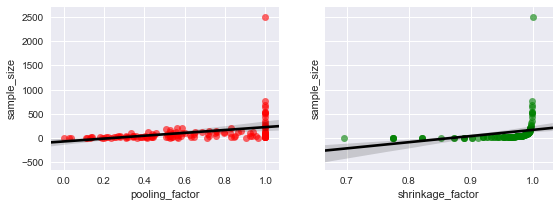

In [980]:
print('Number of town centres with shrinkage factor higher than 0.8 - {}'.format(len(pooling_factors[pooling_factors['shrinkage_factor'] > 0.8])))

f

Let's now proceed by taking an ESDA analysis to check whether we need to integrate a spatial component into the model.

In [982]:
# aggregate business rates per town centre boundary
agg_br = np.log(ldc_data.groupby('cluster_id')['total_value'].mean()).to_frame()

moran = ps.Moran(agg_br, m)
print("Moran's I: {:f} p-val: {:f}".format(moran.I, moran.p_norm))

Moran's I: -0.051640 p-val: 0.528413


No significant global autocorrelation at global M level, let's check local Moran's.

In [781]:
%%capture
agg_br['br_std'] = (agg_br['total_value'] - agg_br['total_value'].mean()) / agg_br['total_value'].std()
agg_br['w_br_lag_std'] = ps.lag_spatial(m, agg_br['br_std'])

f, ax = plt.subplots(1, figsize=(6, 6))
Insignif = agg_br[agg_br['significant'] == False]
Signif = agg_br[agg_br['significant'] == True]

sns.regplot(x='br_std', y='w_br_lag_std', data=agg_br)
ax.scatter(x='br_std', y='w_br_lag_std', 
           data=Signif, label='Significant', c='b', alpha=.6)
ax.scatter(x='br_std', y='w_br_lag_std', 
           data=Insignif, label='Insignificant', c='r', alpha=.6)

ax.legend()

plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
ax.set_xlim(-2, 4)
ax.set_ylim(-2.5, 2.5)
plt.text(3, 1.5, "HH", fontsize=25)
plt.text(3, -1.5, "HL", fontsize=25)
plt.text(-1, 1.5, "LH", fontsize=25)
plt.text(-1, -1.5, "LL", fontsize=25)
plt.title('$\lambda = -0.05$')
plt.show()

LISA implies small, negative spatial autocorrelation, but local Moran's for individual boundaries are generally insignificant.

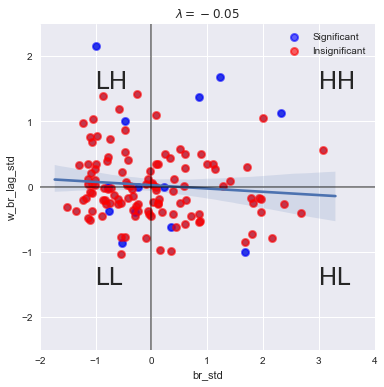

In [782]:
f

Let's check out the posterior densities for lambda.

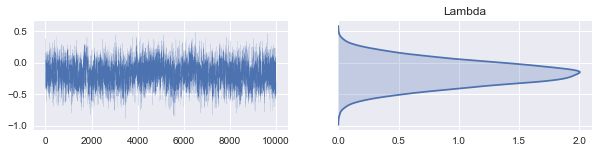

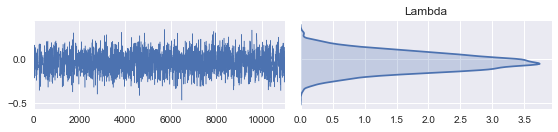

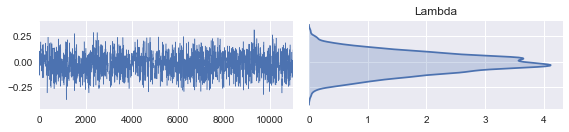

In [248]:
# import r vec
hsar_trace_lambda = pd.read_csv('c:/Users/sgscombe/Documents/test_vec.csv').drop('Unnamed: 0', axis=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2), sharey=True)
ax1.plot(hsar_trace_lambda['x'].values, linewidth=.1)
sns.kdeplot(hsar_trace_lambda['x'].values, shade=True, vertical=True, ax=ax2);
plt.title('Lambda')

f, ax = sese.trace.plot(varnames='Lambda');
f, ax = upper_sma.trace.plot(varnames='Lambda');

In [275]:
lam_sese = spvcm.diagnostics.point_estimates(sese)[0]['Lambda']
sma_sese = spvcm.diagnostics.point_estimates(upper_sma)[0]['Lambda']

In [277]:
# point estimate of MCMC chain error for lambda param
print(lam_sese)
print(sma_sese)

-0.0378254022264
-0.0272123170966


In [91]:
for df in [fe, mlm, hsar, spatial]:
    df.set_index('cluster_id', inplace=True)

store_per_catch = ldc_data.groupby('cluster_id').agg(['count']).iloc[:,1].rename('count').to_frame()

dfs = [fe, mlm, hsar, spatial, store_per_catch, catchments]

catch_map = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dfs) #coalesce to one frame

catch_map = gpd.GeoDataFrame(catch_map, crs={'init': 'epsg:27700'}, geometry=catch_map['geometry'])

In [48]:
%%capture
f, ax = plt.subplots(figsize=(10,8))

manc = gpd.read_file(path+'shps/manchester.shp')
manc.plot(ax=ax, color='#b2b6ba')

hb = ax.hexbin(catch_map.geometry.centroid.x,
          catch_map.geometry.centroid.y, 
          C=catch_map.fe_est, 
          gridsize=15, cmap='PuBu')

hex_coords = [
    ['Middlebrook Retail & Leisure Park, Bolton', 365319.93, 410813.31],
    ['Intu Trafford Centre (The Trafford Centre), Manchester', 375785.42, 396668.75],
    ['Altrincham Retail Park, Altrincham', 375785.42, 388586.15],
    ['Elk Mill Centre Retail Park, Oldham', 392231.19, 406772.01]
]

for name, x, y in hex_coords: # take a few high ests
    plt.text(x, y, name, 
             horizontalalignment='center', 
             verticalalignment='center',
             fontsize=14)
    
f.tight_layout(); ax.set_axis_off()

plt.colorbar(hb)
plt.title('Spatial FE estimates for Greater Manchester', fontsize=15, fontweight='bold')

plt.show()

Let's introduce hex-binning for the spatial FE estimates. Amongst the tesselation, a spatial heteogeneity in the FE is visible, roughly reflecting the principal model of retail hierarchies for Greater Manchester.

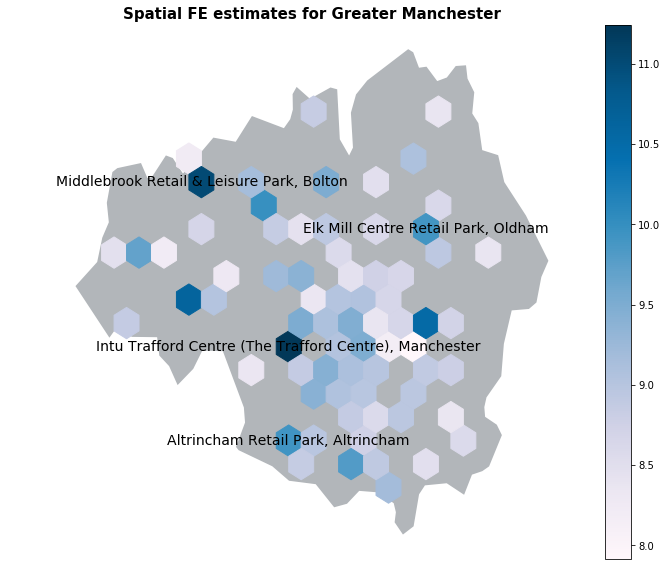

In [49]:
f

Let's now consider a bivariate case where we plot the FE estimate alongside a raw count of the number of stores per town centre boundary. The KDE reveals the multimodal struture and a weak positive linear relationship between the FE estimate and the number of stores contained within the boundary. This intuitivey implies town centre boundaries with a higher number of stores have a increased attractiveness effect associated with them.

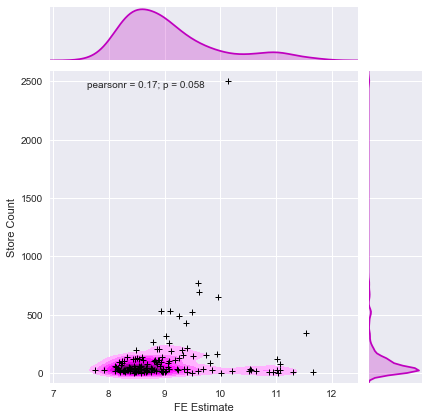

In [780]:
ax = sns.jointplot(x='fe_est', y='count', data=catch_map, kind='kde', color='m')
ax.plot_joint(plt.scatter, c='black', s=30, linewidth=1, marker='+')
ax.ax_joint.collections[0].set_alpha(0)
ax.set_axis_labels('FE Estimate','Store Count');

For a sanity check, let's pairplot each estimator. Diagonals of the grid reveals multimodality which, again, probably infers retail hierachies in the region.

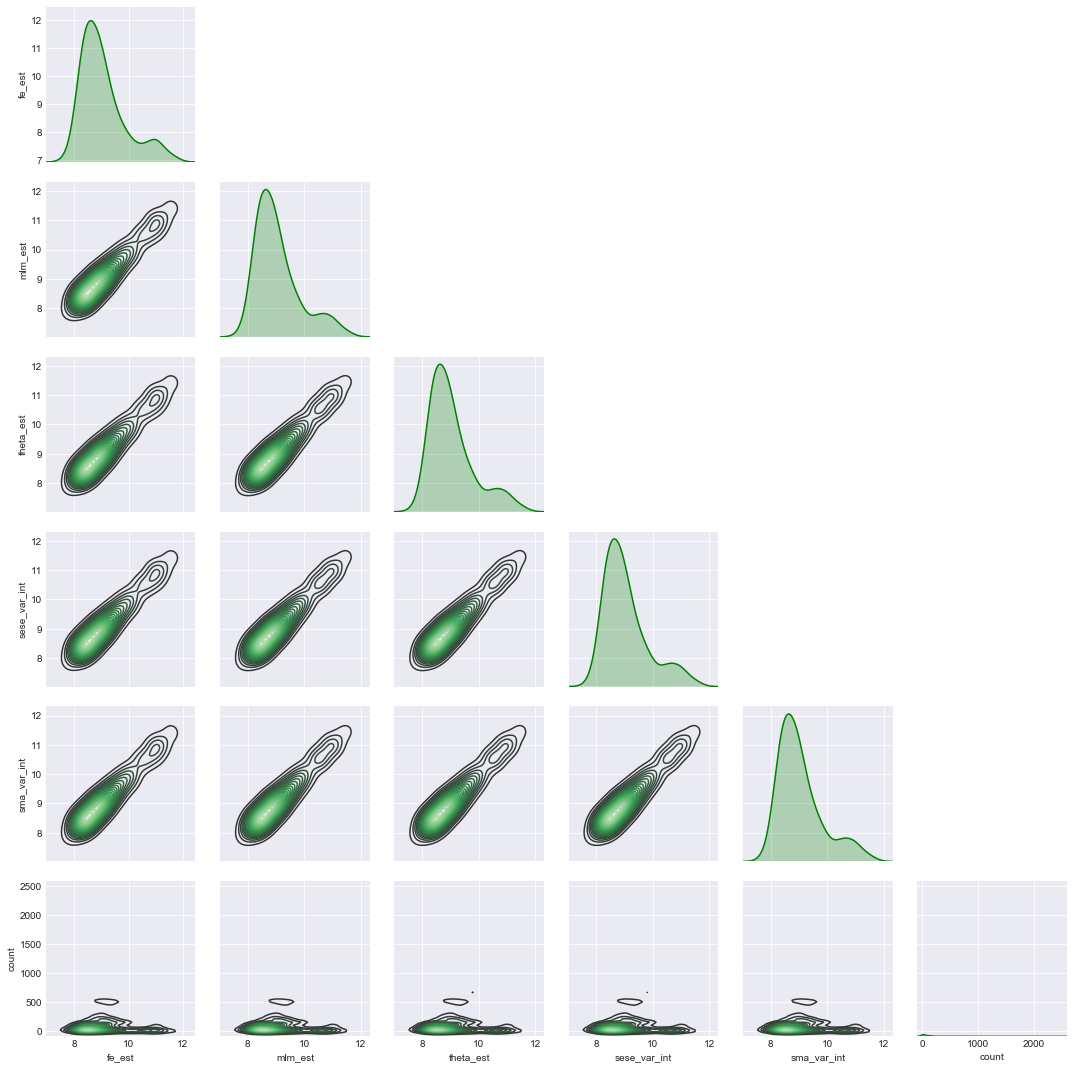

In [140]:
g = sns.PairGrid(catch_map[['fe_est', 'mlm_est', 'theta_est', 'sese_var_int', 'sma_var_int', 'count']]);
g.map_diag(sns.kdeplot, shade=True, color='g', legend=False);
g.map_offdiag(sns.kdeplot, cmap="Greens_d", n_levels=30, legend=False);

for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

Let's check for non-linearity. I opt for a generalized additive model because I find polynomial regression terms clumsy. With GAMs, predictor functions are automatically derived during model estimation, so we don't need to know what type of polynomial we will need up front.

To remind myself, mathematically speaking, GAM is an additive modeling technique where the impact of the predictive variables are captured through smooth functions which — depending on the underlying patterns in the data — can be nonlinear.

Using default splines for the smooth and default lambda (which generally controls the wiggliness), some non-linearity can be observed for the GAM model: $\text{count} \sim \text{fe_est}$. The plot demonstrates some fanning where the spatial FE estimate increases as the number of stores within the town centre boundary increases. 
With 25 splines, the relationship between $X$ and $Y$ looks almost to be monotonically increasing, with a non-linear trend observable from around $9.6$ on the $x$-axis, but generally this non-linearity is distorted by the town centre boundary with the highest number of stores ($2,500$) for Manchester city centre around Corporation Street.

In [257]:
%%capture # ignore annoying warnings
from pygam import LinearGAM
from pygam.utils import generate_X_grid

# iterate over splines and use default lambda .6
a = plt.subplots(1, 2, figsize=(10,5))[1].ravel()
for i, spline in enumerate([15,25]):
    gam = LinearGAM(n_splines=spline, lam=.6).gridsearch(catch_map['fe_est'].values, catch_map['count'].values)
    XX = generate_X_grid(gam)

    a[i].plot(XX, gam.predict(XX), 'r--')
    a[i].plot(XX, gam.prediction_intervals(XX, width=.95), color='#0F0F0F', ls='--')
    a[i].scatter(catch_map['fe_est'], catch_map['count'], s=12, facecolor='gray', edgecolors='none')
    a[i].set_title('{} splines'.format(spline))

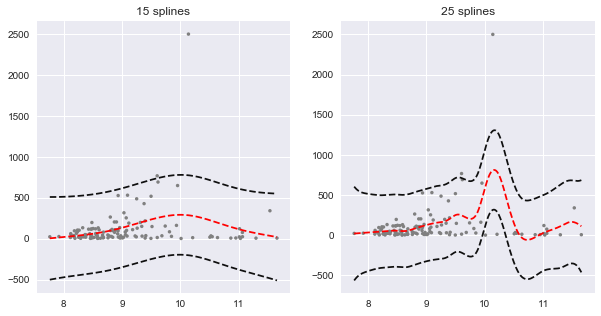

In [258]:
a[1].figure

In [121]:
gam.summary() # 25 splines`

Model Statistics
-------------------------
edof                13.47
AIC              1776.241
AICc             1780.184
GCV             60919.654
loglikelihood     -873.65
deviance           115.53
scale           49588.124

Pseudo-R^2
----------------------------
explained_deviance     0.312
McFadden               0.029
McFadden_adj           0.014


Now we regress our estimated attractiveness indicator on LSOA variables as a validation step. 

These are percent unemployed, percent of people with good health and percent of people with no education. These are aggregated using a group by mean of LSOAs inside the town centre boundary, so are hardly accurate and suseptible to MUAP, but they should provide some indication to the performance of our indicator.

In [29]:
lsoa = gpd.read_file(path+'/shps/Lower_Layer_Super_Output_Areas_December_2011_Full_Extent__Boundaries_in_England_and_Wales.shp')
catch_map.crs = lsoa.crs

# return all lsoas that intersect the town centre boundaries 
catch_map_lsoa = sjoin(catch_map, lsoa, op='intersects', how='right')

In [26]:
# build dataframes for each variable
ec_act = pd.read_csv(path+'/data/lsoa_grp/ec_act.csv')
ec_act = ec_act[['geography code', 'Economic Activity: All usual residents aged 16 to 74; measures: Value', 'Economic Activity: Economically active: Unemployed; measures: Value']]
ec_act.columns = ['lsoa11cd', 'all_ec', 'ec_act']
ec_act['percent_unemp'] = ec_act.apply(lambda row : (row['ec_act'] / row['all_ec']) *100, axis=1)

health = pd.read_csv(path+'/data/lsoa_grp/health.csv')
health = health[['geography code','disability/health/care: All categories: Long-term health problem or disability; measures: Value','disability/health/care: Very good health; measures: Value']]
health.columns = ['lsoa11cd', 'all_health', 'number_good_health']
health['percent_good_health'] = health.apply(lambda row : (row['number_good_health'] / row['all_health']) * 100, axis=1)

educ = pd.read_csv(path+'/data/lsoa_grp/education.csv')
educ = educ[['geography code', 'Qualification: All categories: Highest level of qualification; measures: Value', 'Qualification: No qualifications; measures: Value']]
educ.columns = ['lsoa11cd', 'all_educ', 'percent_no_educ']
educ['percent_no_educ'] = educ.apply(lambda row : (row['percent_no_educ'] / row['all_educ']) * 100, axis=1)

price = pd.read_csv(path+'/data/lsoa_grp/house_price.csv')
price = price[['LSOA code', 'Year ending Jun 2017']]
price.columns = ['lsoa11cd', 'price_2017']
price = price[price['price_2017'] != ':']
price['price_2017'] = price['price_2017'].apply(lambda x : int(x.replace(',','')))

In [1096]:
dfs = [catch_map_lsoa, ec_act, health, educ, price]

catch_map_lsoa = reduce(lambda left,right: pd.merge(left,right, on='lsoa11cd'), dfs) #coalesce to one frame

In [1097]:
cluster_unemp = catch_map_lsoa.dropna().groupby('index_left')['percent_unemp'].mean()
cluster_health = catch_map_lsoa.dropna().groupby('index_left')['percent_good_health'].mean()
cluster_educ = catch_map_lsoa.dropna().groupby('index_left')['percent_no_educ'].mean()
cluster_price = catch_map_lsoa.dropna().groupby('index_left')['price_2017'].mean()

dfs = [catch_map, cluster_unemp.to_frame(), cluster_health.to_frame(), cluster_educ.to_frame(), cluster_price.to_frame()]

catch_map_lsoa = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dfs) #coalesce to one frame

Let's regress the random intercept estimate from the classical MLM model on the chosen variables.

In [1103]:
import statsmodels.api as sm;

X = catch_map_lsoa[['percent_unemp', 'percent_good_health', 'percent_no_educ', 'price_2017']]
X = sm.add_constant(X)
y = catch_map_lsoa['mlm_est']
model = sm.OLS(y, X)
results = model.fit()

And our results are unconvincing...

In [1102]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mlm_est   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                   0.04477
Date:                Tue, 27 Mar 2018   Prob (F-statistic):              0.996
Time:                        16:47:21   Log-Likelihood:                -1434.0
No. Observations:                 129   AIC:                             2878.
Df Residuals:                     124   BIC:                             2892.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6478.6618   2.92e+04      0.222      0.825   -5.14e+04    6.43e+04
percent_unemp         182.9999   1379.004      0.133      0.895   -2546.434    2912.434
percent_good_health   126.4304    489.671      0.258      0.797    -842.765    1095.626
percent_no_educ        23.2703    397.916      0.058      0.953    -764.317     810.858
price_2017             -0.0066      0.025     -0.265      0.791      -0.056       0.042
==============================================================================
Omnibus:                      106.496   Durbin-Watson:                   0.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              755.488
Skew:                           3.056   Prob(JB):                    8.87e-165
Kurtosis:                      13.159   Cond. No.                     3.80e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.8e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""